# Using Gradient Decent to find the Best Cuts on 2D Data

Lets try looking at the performance of different signals, with a 2D signal rather than a single dimension. Lets also use the full `haiku` infrastructure to prepare for training cuts with NN's.

In [1]:
# This cell magic will both run the cell, and also emit it to an output file.
from util_nb import write_and_run

In [2]:
from samples import data_2D_sig, data_2D_back
from jax_cuts import cut_erf, loss_sig_sqrt_b, cut_sigmoid, loss_x_entropy, loss_squares

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

_ = plt.ion()

Create a complete array that has the values and the answers. The current signal and background samples aren't the same size. This just makes the loss function harder to see. So - lets create a signal sample that is as big as the background sample.

In [3]:
training_data = jnp.concatenate((data_2D_back, data_2D_sig))
training_truth = jnp.concatenate((jnp.zeros(len(data_2D_back)), jnp.ones(len(data_2D_sig))))

2022-12-30 10:08:48.030320: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Loss Function Plots

This is trying to solve this by brute force - by looking at the full 2D plots for the loss function.

In [4]:
def get_min_max(data):
    data_max = max(jnp.max(data), jnp.max(data))
    data_min = min(jnp.min(data), jnp.min(data))
    lower_limit = data_min - (abs(data_min) * 0.2)
    upper_limit = data_max + (abs(data_max) * 0.2)
    return lower_limit, upper_limit


lower_x, upper_x = get_min_max(training_data[:, 0])
lower_y, upper_y = get_min_max(training_data[:, 1])

x_values = np.linspace(lower_x, upper_x, 50)
y_values = np.linspace(lower_y, upper_y, 50)

X, Y = np.meshgrid(x_values, y_values)


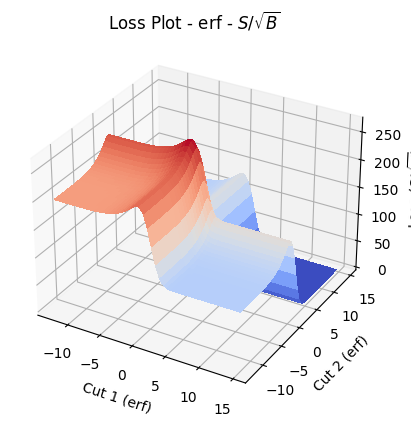

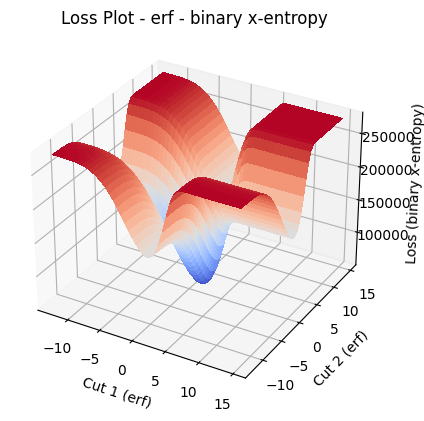

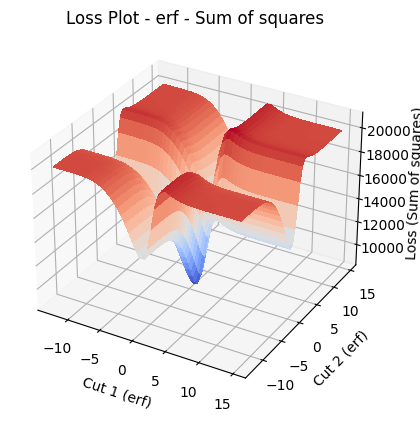

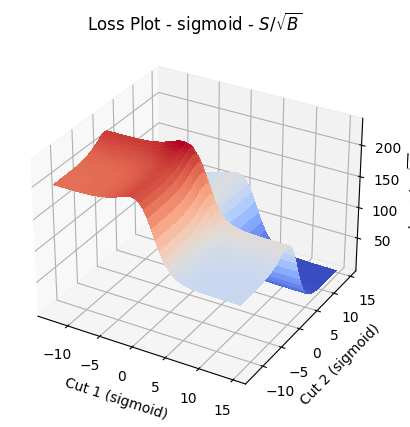

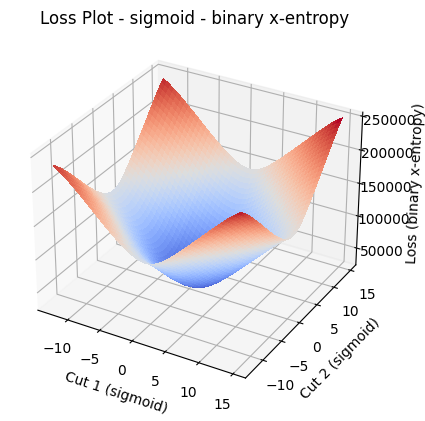

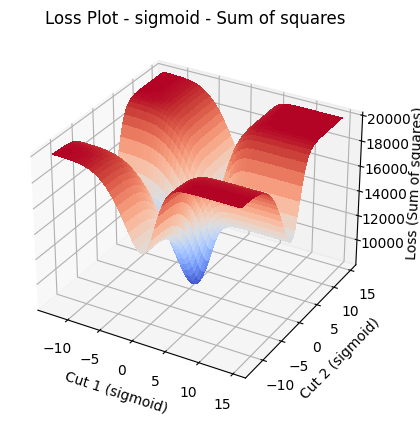

In [5]:
# %matplotlib widget
import functools as ft

from jax_cuts import loss_x_entropy


def calc_loss(f_cut, f_merit, x_cut, y_cut):
    def calc_1D_loss(cut, sig, back):
        return f_merit(ft.partial(f_cut, cut), sig, back)

    return calc_1D_loss(x_cut, data_2D_sig[:, 0], data_2D_back[:, 0]) + calc_1D_loss(
        y_cut, data_2D_sig[:, 1], data_2D_back[:, 1]
    )


def plot_2D_loss(f_cut, f_cut_name, f_merit, f_merit_name):
    "Plot the 3D contour for a loss function"
    loss = np.array(
        [
            [
                calc_loss(f_cut, f_merit, X[i_x, i_y], Y[i_x, i_y])
                for i_y in range(len(y_values))
            ]
            for i_x in range(len(x_values))
        ]
    )

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, loss, linewidth=0, antialiased=False, cmap=cm.coolwarm)
    ax.set_xlabel(f"Cut 1 ({f_cut_name})")
    ax.set_ylabel(f"Cut 2 ({f_cut_name})")
    ax.set_zlabel(f"Loss ({f_merit_name})")

    plt.title(f"Loss Plot - {f_cut_name} - {f_merit_name}")

    plt.show()


for f_cut, f_cut_name in ((cut_erf, "erf"), (cut_sigmoid, "sigmoid")):
    for f_merit, f_merit_name in (
        (loss_sig_sqrt_b, r"$S/\sqrt{B}$"),
        (loss_x_entropy, "binary x-entropy"),
        (loss_squares, "Sum of squares"),
    ):
        plot_2D_loss(f_cut, f_cut_name, f_merit, f_merit_name)


## ML Search for the best Cut Values using the Haiku Library

[Haiku](https://github.com/deepmind/dm-haiku) uses modules. We need to build the modules necessary to apply the cuts we are interested in.

The module code is stashed in the file `jax_haiku.py` file so it can be used downstream.

In [6]:
%%write_and_run jax_training.py
import haiku as hk
from typing import Optional, List, Callable, Dict
import jax
import jax.numpy as jnp
import optax
from optax import Params
import math

In [7]:
%%write_and_run -a jax_training.py


class Selection(hk.Module):
    """Apply a selection cut to each input, output is a weight,
    zero if the cut would reject, one if it would not"""

    def __init__(
        self,
        f_cut: Callable,
        initial_cuts: Optional[List[float]] = None,
        name="SelectionCut",
    ):
        super().__init__(name=name)
        self._initial_cuts = initial_cuts
        self._f_cut = f_cut

    def __call__(self, x):
        "Apply a selection cut for all the incoming data."

        # See if we have a decent set of initializers
        cuts_initial = (
            jnp.asarray(self._initial_cuts)
            if self._initial_cuts is not None
            else jnp.ones(x.shape[1])
        )
        assert (
            cuts_initial.shape[0] == x.shape[1]
        ), f"Incorrect number of initial cut values specified - need {x.shape[1]}"

        # Get the parameters to apply here
        cuts = hk.get_parameter(
            "cuts",
            shape=[x.shape[1]],
            dtype=jnp.float32,
            init=lambda shp, dtyp: cuts_initial,
        )

        # Next, apply the cut
        cut_data_pairing = [
            (cuts[index], x[:, index]) for index in range(0, x.shape[1])
        ]
        wts = jnp.stack([self._f_cut(c, x_col) for c, x_col in cut_data_pairing],
                        axis=1)

        return jnp.prod(wts, axis=1)

## Training Loop

And we need some sort of simple training loop to find our minimum (do not use the $S/\sqrt{B}$ loss function  as that is a maximum!).

In [8]:
%%write_and_run -a jax_training.py


def default_loss(preds, actual):
    upped = jax.nn.sigmoid(preds)
    return optax.softmax_cross_entropy(upped, actual)


def train(
    model,
    key,
    epochs,
    training_data,
    training_truth,
    learning_rate=0.002,
    use_loss_function=default_loss,
    epoch_callback=None,
) -> Dict:
    """Run the training with the specified loss and model.

    - Simple loop with gradient feedback, one iteration per epoch
    - uses the `optax.adam` optimizer with the given learning rate.

    Args:
        model (_type_): The model to train
        key (_type_): Random number key for initalization
        epochs (_type_): How many training epochs to run
        training_data (_type_): The training data vector (signal and background)
        training_truth (_type_): A 1D vector that indicates signal or background for
                                 each training data entry.
        learning_rate (float, optional): How quickly to adjust the adam optimizer.
                                         Defaults to 0.002.
        epoch_callback (Callable, optional): called with (epoch_index, parameters) after
                                             each training epoch.

    Returns:
        Dict: The final training parameters.
    """
    # Initialize the weights
    key, _ = jax.random.split(key)
    params = model.init(key, training_data)  # type: optax.Params

    # Init the optimizer
    opt_init, opt_update = optax.chain(optax.adam(learning_rate), optax.zero_nans())
    opt_state = opt_init(params)

    # Build the loss function
    def loss_func(weights, input_data, actual):
        "Calc the loss function"
        preds = model.apply(weights, key, input_data)
        preds = preds.squeeze()
        return use_loss_function(preds, actual)
        # preds = jax.nn.sigmoid(preds)
        # return optax.softmax_cross_entropy(preds, actual)

    neg_loss_func = jax.jit(jax.value_and_grad(loss_func))

    # Train
    report_interval = int(epochs / 10)
    old_params: Optional[Params] = None
    old_loss = 1000
    bad_loss = False
    for i in range(1, epochs + 1):
        loss, param_grads = neg_loss_func(params, training_data, training_truth)
        updates, opt_state = opt_update(param_grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        if math.isnan(loss):
            print("WARNING: Loss is nan - returning last good epoch")
            assert (
                old_params is not None
            ), "Fatal error - did not make it a single iteration"
            params = old_params
            loss = old_loss
            bad_loss = True

        if epoch_callback is not None:
            epoch_callback(i, params)

        if i % report_interval == 0 or i == 1 or bad_loss:
            print(f"NegLogLoss : {loss:.2f}, epoch: {i}")

        if bad_loss:
            break

        old_params = params
        old_loss = loss

    assert params is not None
    return params  # type:ignore

In [9]:
%%write_and_run -a jax_training.py


def train_cut(
    t_data,
    t_truth,
    f_cut: Callable,
    epochs=10,
    initial_cuts=(1.0, 1.0),
    use_loss_function=default_loss,
):
    """Simplify training a cut by setting default parameters for everything else.

    Args:
        f_cut (_type_): The Callable that can perform the cut
    """

    def model_builder(x):
        cuts = Selection(f_cut, initial_cuts=initial_cuts)
        return cuts(x)

    model = hk.transform(model_builder)
    key = jax.random.PRNGKey(1234)

    return train(
        model, key, epochs, t_data, t_truth, use_loss_function=use_loss_function
    )

## Training

Train and plot the results of a simple 2D training for the cuts we are looking at.

In [10]:
sigmoid_cut_results = train_cut(training_data, training_truth, cut_sigmoid, 5000)['SelectionCut']['cuts']
print(f'Sigmoid cut results = {sigmoid_cut_results}')

NegLogLoss : 98698.24, epoch: 1
NegLogLoss : 98554.80, epoch: 500
NegLogLoss : 98512.15, epoch: 1000
NegLogLoss : 98504.36, epoch: 1500
NegLogLoss : 98503.14, epoch: 2000
NegLogLoss : 98502.99, epoch: 2500
NegLogLoss : 98502.98, epoch: 3000
NegLogLoss : 98502.98, epoch: 3500
NegLogLoss : 98502.98, epoch: 4000
NegLogLoss : 98502.98, epoch: 4500
NegLogLoss : 98502.98, epoch: 5000
Sigmoid cut results = [-1.0773739 -0.3744329]


In [11]:
erf_cut_results = train_cut(training_data, training_truth, cut_erf, 5000)['SelectionCut']['cuts']
print(f'Error Function cut results = {erf_cut_results}')

NegLogLoss : 98528.81, epoch: 1
NegLogLoss : 98332.62, epoch: 500
NegLogLoss : 98309.32, epoch: 1000
NegLogLoss : 98307.33, epoch: 1500
NegLogLoss : 98307.22, epoch: 2000
NegLogLoss : 98307.21, epoch: 2500
NegLogLoss : 98307.21, epoch: 3000
NegLogLoss : 98307.21, epoch: 3500
NegLogLoss : 98307.21, epoch: 4000
NegLogLoss : 98307.21, epoch: 4500
NegLogLoss : 98307.21, epoch: 5000
Error Function cut results = [-0.3469715   0.23541719]


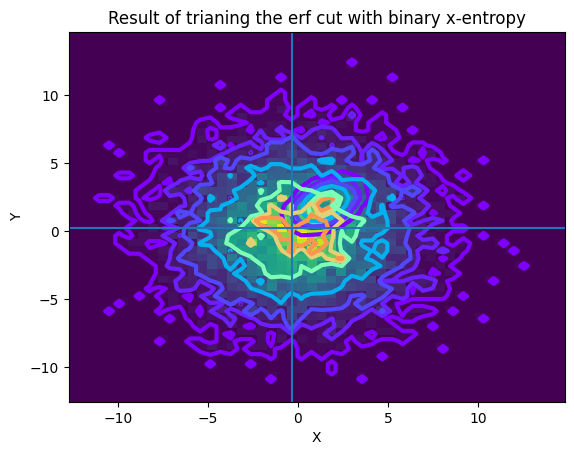

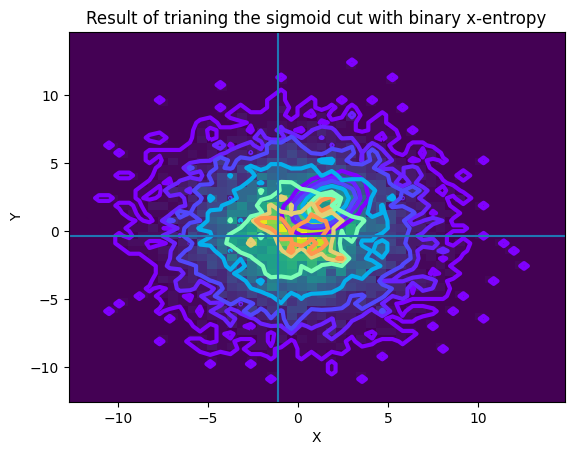

In [12]:
def plot_training_resuts(cut_results, cut_name:str):
    def plot_contour(data):
        counts,xbins,ybins,_ = plt.hist2d(data[:, 0], data[:, 1], bins=50, range=((lower_x, upper_x), (lower_y, upper_y)))
        max_count = max([max(c) for c in counts])
        color_levels = list(np.array([1,5,10,25,50,70,80,100]) * max_count/100)
        plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=3, cmap = plt.cm.rainbow, levels = color_levels)
    plot_contour(data_2D_sig)
    plot_contour(data_2D_back)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axhline(cut_results[1])
    plt.axvline(cut_results[0])
    plt.title(f'Result of trianing the {cut_name} cut with binary x-entropy')
    plt.show()

plot_training_resuts(erf_cut_results, 'erf')
plot_training_resuts(sigmoid_cut_results, 'sigmoid')

The `erf` and `sigmoid` have very different cut values! The `erf` clearly is in the meat of the signal on these plots.

## Training Far From The Central Value

By default these trainings have started with a cut value of 1. Lets see what happens when we start them with a cut value of 30 - will they eventually find the right result?

In [13]:
sigmoid_cut_results_faraway = train_cut(training_data, training_truth, cut_sigmoid, 5000, initial_cuts=(60.0, 60.0))['SelectionCut']['cuts']
print(f'Sigmoid cut results = {sigmoid_cut_results_faraway}')

NegLogLoss : 99034.87, epoch: 1
NegLogLoss : 99034.87, epoch: 500
NegLogLoss : 99034.87, epoch: 1000
NegLogLoss : 99034.87, epoch: 1500
NegLogLoss : 99034.87, epoch: 2000
NegLogLoss : 99034.87, epoch: 2500
NegLogLoss : 99034.87, epoch: 3000
NegLogLoss : 99034.87, epoch: 3500
NegLogLoss : 99034.87, epoch: 4000
NegLogLoss : 99034.87, epoch: 4500
NegLogLoss : 99034.87, epoch: 5000
Sigmoid cut results = [60. 60.]


In [14]:
erf_cut_results_faraway = train_cut(training_data, training_truth, cut_erf, 5000, initial_cuts=(60.0, 60.0))['SelectionCut']['cuts']
print(f'Sigmoid cut results = {erf_cut_results_faraway}')

NegLogLoss : 99034.87, epoch: 1
NegLogLoss : 99034.87, epoch: 500
NegLogLoss : 99034.87, epoch: 1000
NegLogLoss : 99034.87, epoch: 1500
NegLogLoss : 99034.87, epoch: 2000
NegLogLoss : 99034.87, epoch: 2500
NegLogLoss : 99034.87, epoch: 3000
NegLogLoss : 99034.87, epoch: 3500
NegLogLoss : 99034.87, epoch: 4000
NegLogLoss : 99034.87, epoch: 4500
NegLogLoss : 99034.87, epoch: 5000
Sigmoid cut results = [60. 60.]


As it stands - when that far out there is nothing that is provided here - so training really does not work at all. We'll have to add something artificial I would think!

## Different Loss Functions

I'm partiuclarly interested in what happens when we use the $S/\sqrt(B)$ as opposed to the binary x-entropy used above.

Sadly, doing this calculation isn't trivial - so we will leave this until later.